In [1]:
import math
import os
import json
import random
import numpy as np
from tqdm import tqdm
import seaborn as sns
import zipfile
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Subset
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
import torch.nn as nn
from torchvision import transforms
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import time

print(torch.backends.mps.is_available())
BASEPATH = Path("__file__").parent.resolve()

/Users/danny/Desktop/programming/CV/vision-practice/cenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(device)

mps


In [3]:
BASEPATH

PosixPath('/Users/danny/Desktop/programming/CV/vision-practice')

# 1.0 Data Preparation

## Unzip the Training Data

In [ ]:
zip_file_path = str(BASEPATH / 'Chessman-image-dataset-20241109T174139Z-001.zip')
extract_to_directory = str(BASEPATH / 'Chessman-image-dataset')
os.makedirs(extract_to_directory, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print(f"Files extracted to {extract_to_directory}")

Files extracted to /content/Chessman-image-dataset


In [4]:
DATA_DIR = str(BASEPATH / 'Chessman-image-dataset' / 'Chess')
chess_classes = os.listdir(DATA_DIR)

In [5]:
print(chess_classes)

['Bishop', 'Rook', 'Pawn', 'Knight', 'King', 'Queen']


In [6]:
num_labels = len(chess_classes)

chess_to_label = {chess: idx for idx, chess in enumerate(chess_classes)}
label_to_chess = {idx: chess for chess, idx in chess_to_label.items()}


print(num_labels)
print(chess_to_label)
print(label_to_chess)

with open(str(BASEPATH / 'class_labels.json'), 'w') as json_file:
    json.dump(label_to_chess, json_file)

6
{'Bishop': 0, 'Rook': 1, 'Pawn': 2, 'Knight': 3, 'King': 4, 'Queen': 5}
{0: 'Bishop', 1: 'Rook', 2: 'Pawn', 3: 'Knight', 4: 'King', 5: 'Queen'}


## 1.1 Data Augmentation

In [7]:
class ImageAugmentation:
    def __init__(self, base_path, data_dir):
        self.base_path = base_path
        self.data_dir = data_dir
        self.common_transforms = [
            transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
            # transforms.ToTensor()  # Convert the image to a PyTorch tensor
        ]
        self.transformations = self.define_transformations()
        self.dataset = datasets.ImageFolder(root=self.data_dir)
        print("Size of the data before Augmentation:", len(self.dataset))
        self.to_pil_image = transforms.ToPILImage()

    def define_transformations(self):
        return [
            transforms.Compose([*self.common_transforms, transforms.RandomHorizontalFlip(), transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.01), transforms.ToTensor()]),
            transforms.Compose([*self.common_transforms, transforms.RandomHorizontalFlip(), transforms.RandomRotation(degrees=10), transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)), transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), transforms.ToTensor()]),
            transforms.Compose([*self.common_transforms, transforms.RandomRotation(20), transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05), transforms.RandomVerticalFlip(), transforms.ToTensor()]),
            transforms.Compose([*self.common_transforms, transforms.RandomRotation(15), transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01, hue=0.08), transforms.RandomHorizontalFlip(), transforms.ToTensor()]),
            transforms.Compose([*self.common_transforms, transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.01), transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), transforms.RandomVerticalFlip(), transforms.ToTensor()]),
            transforms.Compose([*self.common_transforms, transforms.RandomRotation(10), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)), transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05), transforms.ToTensor()]),
            transforms.Compose([*self.common_transforms, transforms.RandomRotation(15), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02), transforms.ToTensor()]),
            transforms.Compose([*self.common_transforms, transforms.RandomRotation(20), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)), transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.03), transforms.ToTensor()]),
            transforms.Compose([*self.common_transforms, transforms.RandomRotation(25), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)), transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.04), transforms.ToTensor()]),
            transforms.Compose([*self.common_transforms, transforms.RandomRotation(30), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)), transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.05), transforms.ToTensor()])
        ]

    def display(self, image_path):
        original_image = Image.open(image_path)
        images_per_row = 5
        total_images = len(self.transformations) + 1
        num_rows = math.ceil(total_images / images_per_row)

        plt.figure(figsize=(15, 5 * num_rows))

        plt.subplot(num_rows, images_per_row, 1)
        plt.title('Original Image')
        plt.imshow(original_image)
        plt.axis('off')

        for i, transform in enumerate(self.transformations, start=2):
            transformed_image = transform(original_image)

            if isinstance(transformed_image, torch.Tensor):
                transformed_image = transformed_image.permute(1, 2, 0).numpy()

            plt.subplot(num_rows, images_per_row, i)
            plt.title(f'Transformed Image {i-1}')
            plt.imshow(transformed_image)
            plt.axis('off')

        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        plt.tight_layout()
        plt.show()

    def process_image(self, img_path, label_idx, combined_save_dir):
        original_img = Image.open(img_path)
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        class_name = self.dataset.classes[label_idx]

        original_combined_path = os.path.join(combined_save_dir, class_name, f'{img_name}.jpg')
        os.makedirs(os.path.join(combined_save_dir, class_name), exist_ok=True)
        original_img.save(original_combined_path)

        for t_idx, transform in enumerate(self.transformations):
            transformed_img = transform(original_img)
            transformed_img_pil = self.to_pil_image(transformed_img)
            transformed_combined_path = os.path.join(combined_save_dir, class_name, f'{img_name}_transformed{t_idx+1}.jpg')
            transformed_img_pil.save(transformed_combined_path)

    def save_transformed_images(self):
        transformed_save_dir = os.path.join(self.base_path, 'aug_chess_input')
        combined_save_dir = os.path.join(self.base_path, 'combined_chess_input')

        os.makedirs(transformed_save_dir, exist_ok=True)
        os.makedirs(combined_save_dir, exist_ok=True)

        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(self.process_image, img_path, label_idx, combined_save_dir)
                       for img_path, label_idx in self.dataset.imgs]
            for future in tqdm(futures, total=len(futures), desc="Processing images"):
                future.result()

In [8]:
augmenter = ImageAugmentation(BASEPATH, DATA_DIR)

Size of the data before Augmentation: 552


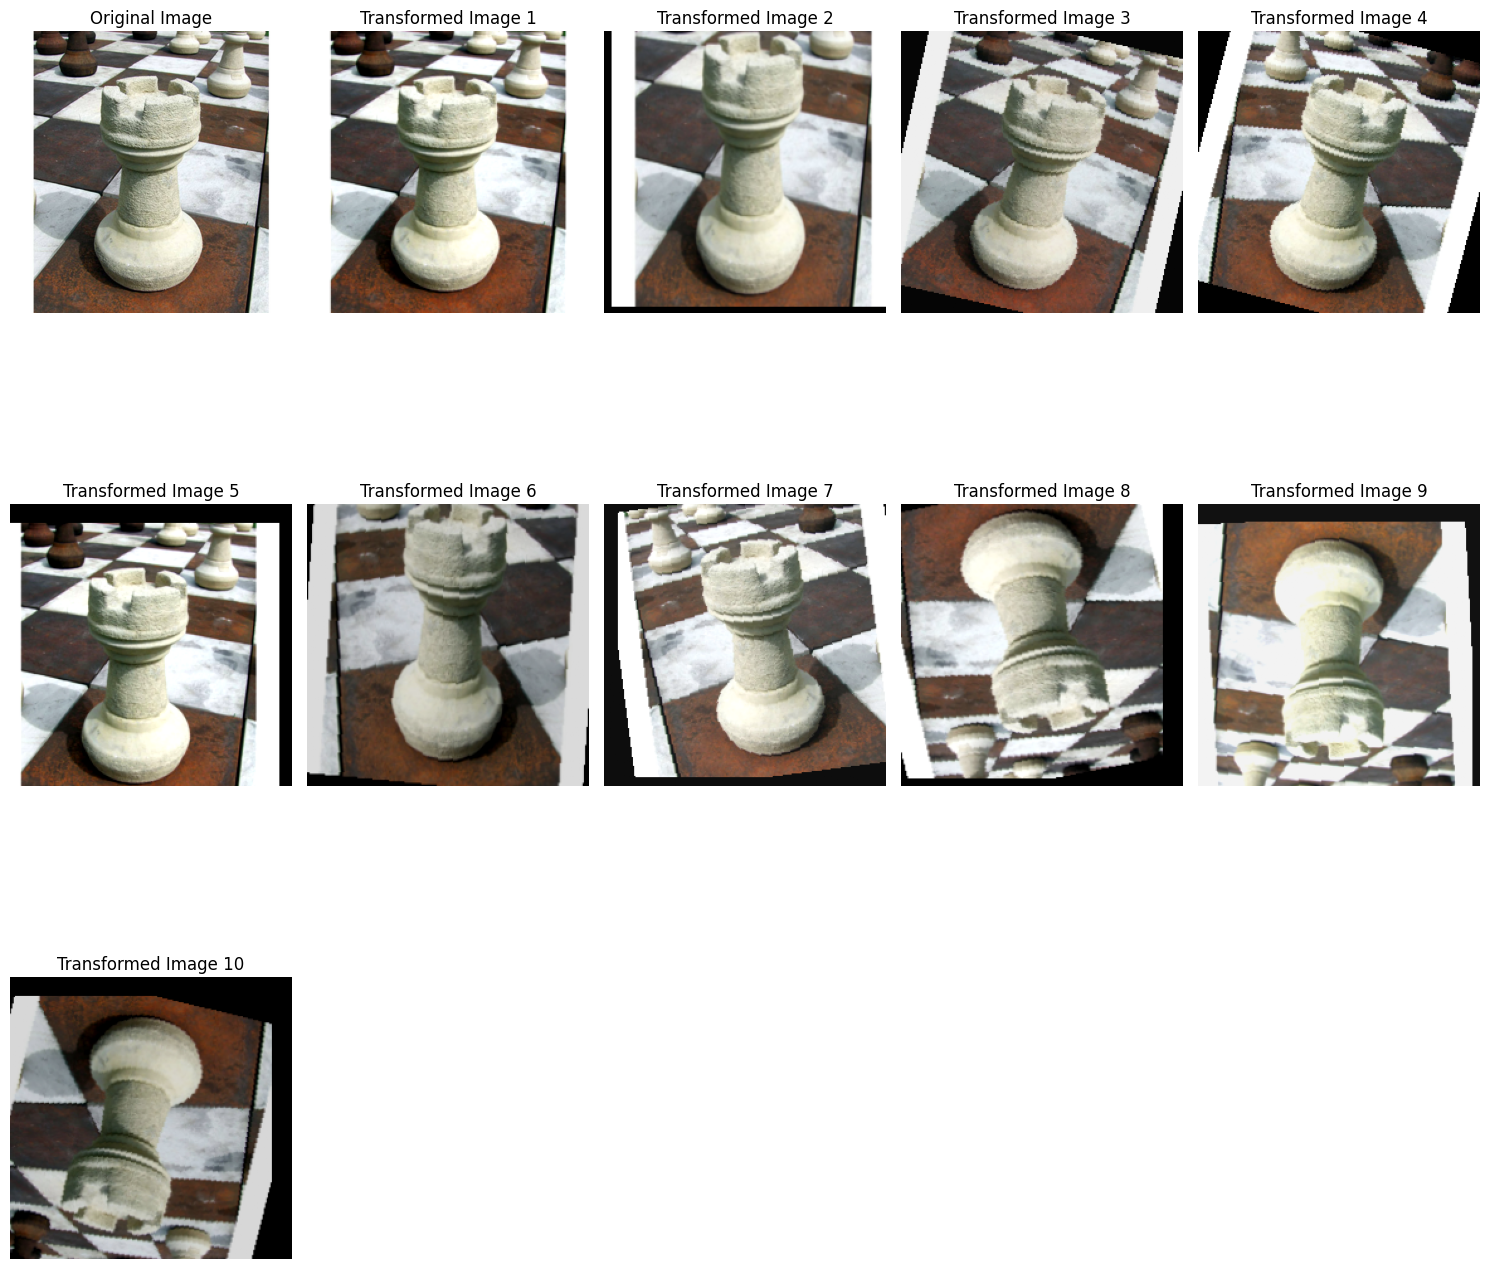

In [9]:
augmenter.display(str(BASEPATH / 'Chessman-image-dataset' / 'Chess' / 'Rook' / '00000022.jpg'))

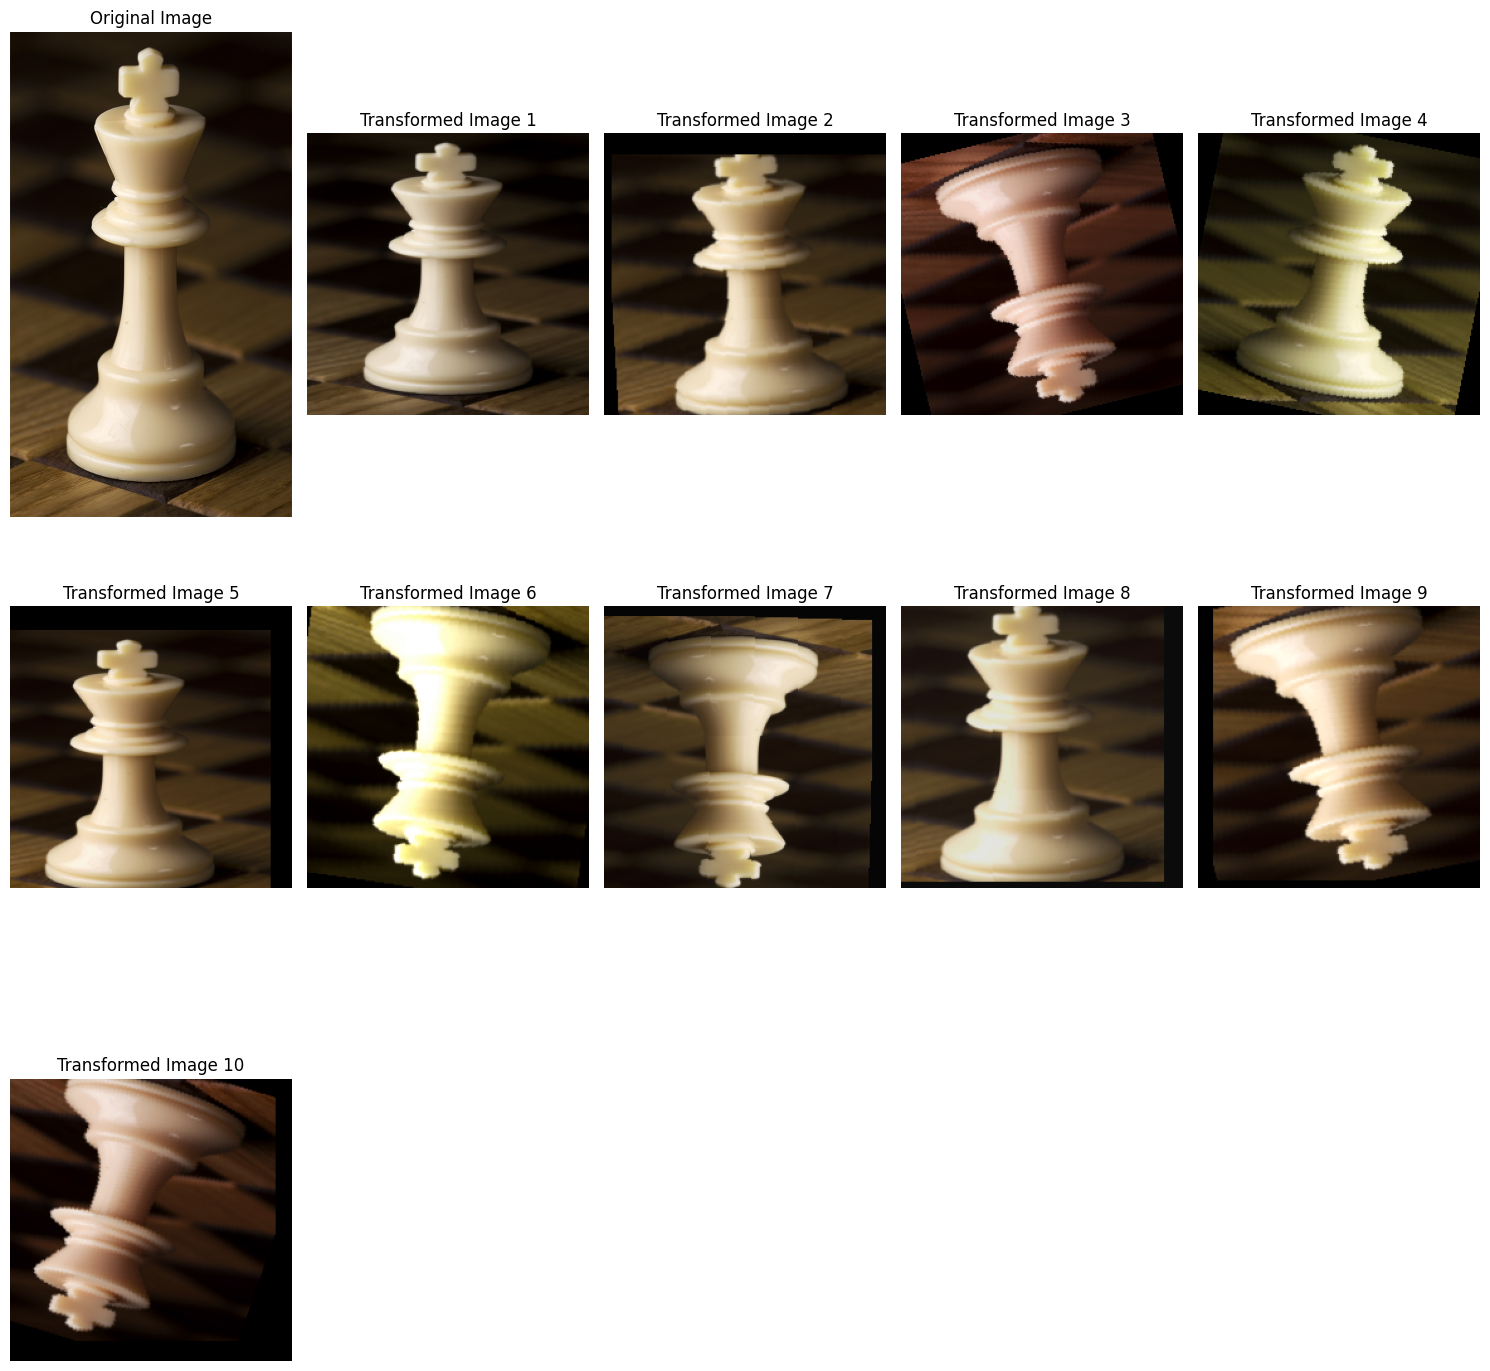

In [10]:
augmenter.display(str(BASEPATH / 'Chessman-image-dataset' / 'Chess' / 'King' / '00000007.jpg'))

In [12]:
augmenter.save_transformed_images()

Processing images: 100%|██████████| 552/552 [00:17<00:00, 31.98it/s]


In [13]:
aug_dir = str(BASEPATH / 'combined_chess_input')
chess = random.choice(chess_classes)
img_fnames = os.listdir(f'{aug_dir}/{chess}')
img_path = f'{aug_dir}/{chess}/{random.choice(img_fnames)}'

img = Image.open(img_path).convert('RGB')
img = np.asarray(img)
label = chess_to_label[chess]

image_shape=(224, 224, 3)


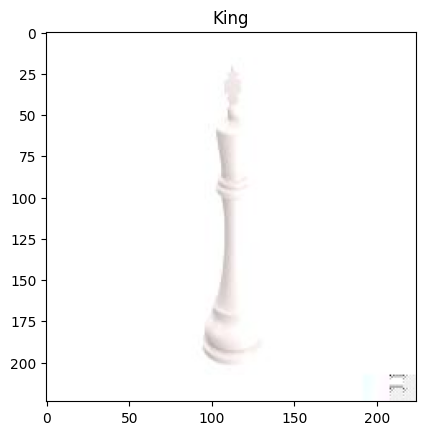

In [14]:
print(f'image_shape={img.shape}')
plt.imshow(img)
plt.title(label_to_chess[label])
plt.show()

## 1.2 Split the dataset

In [15]:
class ImageDataset(Dataset):
    """
    A dataset class for loading images from a directory and applying transformations.

    Attributes:
        data_dir (str): The directory containing the images.
        chess_to_label (dict): A dictionary mapping chess piece names to labels.
        data (list): A list of tuples containing image paths and labels.
        transform (callable): A function/transform to apply to the images.
    """

    def __init__(self, data_dir, chess_to_label):
        """
        Initializes the ImageDataset with the specified directory and label mapping.

        Args:
            data_dir (str): The directory containing the images.
            chess_to_label (dict): A dictionary mapping chess piece names to labels.
        """
        self.data_dir = data_dir
        self.chess_to_label = chess_to_label
        self.data = []

        chesse = os.listdir(self.data_dir)
        for chess in tqdm(chesse, desc="Loading dataset"):
            image_fnames = [i for i in os.listdir(f'{self.data_dir}/{chess}') if not i.startswith('.')]
            for image_fname in image_fnames:
                img_path = f'{self.data_dir}/{chess}/{image_fname}'
                label = self.chess_to_label[chess]
                self.data.append((img_path, label))

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Gets the sample at the specified index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image path, the transformed image tensor, and the label.
        """
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        # Check if the image size is greater or less than (224, 224) and resize if necessary
        if img.size[0] > 224 or img.size[1] > 224 or img.size[0] < 224 or img.size[1] < 224:
            img = transforms.Resize((224, 224))(img)
        tensor_img = ToTensor()(img)

        return (img_path, tensor_img, label)


In [16]:
combined_dataset = ImageDataset(aug_dir, chess_to_label)

Loading dataset: 100%|██████████| 6/6 [00:00<00:00, 759.10it/s]


In [17]:
print(len(combined_dataset))
print(combined_dataset[0][1].shape)

6072
torch.Size([3, 224, 224])


In [18]:
val_ratio = 0.06
test_size = 30

val_size = int(len(combined_dataset) * val_ratio)
train_size = len(combined_dataset) - (val_size + test_size)

train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

In [19]:
print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 5678, val: 364, test: 30


In [20]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False)

# 2.0 Model Selection and Enhancement

In [21]:
print(num_labels)

6


## 2.1 Baseline model

In [22]:
class ChessClassifier(nn.Module):
    """
    A Convolutional Neural Network (CNN) for classifying chess pieces.

    The architecture consists of three convolutional layers followed by three fully connected (dense) layers.
    Each convolutional layer includes a convolution operation, max pooling, batch normalization, ReLU activation,
    and dropout. The fully connected layers include linear transformations, ReLU activation, and dropout (except the final layer).

    Attributes:
        conv1 (nn.Sequential): First convolutional layer.
        conv2 (nn.Sequential): Second convolutional layer.
        conv3 (nn.Sequential): Third convolutional layer.
        fc1 (nn.Sequential): First fully connected layer.
        fc2 (nn.Sequential): Second fully connected layer.
        fc3 (nn.Sequential): Third fully connected layer (output layer).
    """

    def __init__(self, num_labels):
        """
        Initializes the ChessClassifier with the specified number of output labels.

        Args:
            num_labels (int): The number of output labels (classes).
        """
        super(ChessClassifier, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # (224 - 4 + 2 * 1) / 2 + 1 = 112
            nn.MaxPool2d(kernel_size=4, stride=4), # (112 - 4) / 4 + 1 = 28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=1), # (28 - 2 + 2 * 1) / 2 + 1 = 15
            nn.MaxPool2d(kernel_size=3, stride=3), # (15 - 3) / 3 + 1 = 5
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1), # (5 - 2 + 2 * 1) / 1 + 1 = 6
            nn.MaxPool2d(kernel_size=6, stride=1), # (6 - 6) / 1 + 1 = 1
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(256, num_labels)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [23]:
base_model = ChessClassifier(num_labels).to(device)

In [24]:
base_model

ChessClassifier(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=6, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.3, in

In [25]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(base_model.parameters(), lr=0.001)
# Define your learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# checking if GPU is available
if torch.cuda.is_available():
    base_model = base_model.cuda()
    criterion = criterion.cuda()


def train(model, criterion, optimizer, data_loader, device, scheduler=None, is_pretrain=False):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The model to train.
        criterion (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        data_loader (DataLoader): The data loader for the training set.
        device (torch.device): The device to use for training.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): The learning rate scheduler.

    Returns:
        tuple: A tuple containing the training loss and accuracy.
    """
    model.to(device)
    if is_pretrain:
        torch.backends.cudnn.benchmark = True

    model.train()
    train_loss, total, corrects = 0, 0, 0
    for _, inputs, labels in tqdm(data_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        preds = outputs.argmax(dim=1)
        total += len(inputs)
        corrects += (preds == labels).sum().item()

        loss.backward()
        optimizer.step()

    if scheduler is not None:
        scheduler.step()

    train_loss /= len(data_loader)
    train_accuracy = corrects / total

    return train_loss, train_accuracy

def evaluate(model, criterion, data_loader, device):
    """
    Evaluates the model on the validation set.

    Args:
        model (nn.Module): The model to evaluate.
        criterion (nn.Module): The loss function.
        data_loader (DataLoader): The data loader for the validation set.
        device (torch.device): The device to use for evaluation.

    Returns:
        tuple: A tuple containing the validation loss and accuracy.
    """
    model.eval()
    val_loss, total, corrects = 0, 0, 0
    with torch.no_grad():
        for _, inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            total += len(inputs)
            corrects += (preds == labels).sum().item()

    val_loss /= len(data_loader)
    val_accuracy = corrects / total

    return val_loss, val_accuracy

def calculate_metrics(model, data_loader, device):
    """
    Calculates the recall, precision, F1 score, and misclassified classes for the model on the given data loader.

    Args:
        model (nn.Module): The model to evaluate.
        data_loader (DataLoader): The data loader for the evaluation set.
        device (torch.device): The device to use for evaluation.

    Returns:
        tuple: A tuple containing the recall, precision, F1 score, and misclassified classes.
    """
    model.eval()
    y_true = []
    y_pred = []
    corrects, total = 0, 0

    with torch.no_grad():
        for _, inputs, labels in tqdm(data_loader, desc="Calculating Metrics"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            total += len(inputs)
            corrects += (preds == labels).sum().item()

    accuracy = corrects / total
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    cm = confusion_matrix(y_true, y_pred)
    misclassified_percentage = (1 - accuracy) * 100

    return recall, precision, f1, misclassified_percentage, cm

In [26]:
def plot_training_metrics(epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plots the training and validation losses and accuracies over epochs.

    Args:
    - epochs (int): The number of epochs.
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - val_accuracies (list): List of validation accuracies for each epoch.
    """
    # Plot losses
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='train_loss')
    plt.plot(range(epochs), val_losses, label='val_loss')
    plt.legend()
    plt.xticks(range(epochs))
    plt.grid(True)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='train_accuracy')
    plt.plot(range(epochs), val_accuracies, label='val_accuracy')
    plt.legend()
    plt.xticks(range(epochs))
    plt.grid(True)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

In [27]:
epochs = 25
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for epoch in range(epochs):
    train_loss, train_accuracy = train(base_model, criterion, optimizer, train_loader, device, scheduler=scheduler)
    val_loss, val_accuracy = evaluate(base_model, criterion, val_loader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'epoch={epoch + 1}, train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, train_accuracy={train_accuracy:.3f}, val_accuracy={val_accuracy:.3f}')

Evaluating: 100%|██████████| 6/6 [00:00<00:00,  8.42it/s]


epoch=1, train_loss=1.791, val_loss=1.791, train_accuracy=0.188, val_accuracy=0.190


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  8.76it/s]


epoch=2, train_loss=1.775, val_loss=1.779, train_accuracy=0.204, val_accuracy=0.176


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.45it/s]


epoch=3, train_loss=1.762, val_loss=1.759, train_accuracy=0.216, val_accuracy=0.231


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.71it/s]


epoch=4, train_loss=1.748, val_loss=1.742, train_accuracy=0.234, val_accuracy=0.234


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 10.58it/s]


epoch=5, train_loss=1.722, val_loss=1.722, train_accuracy=0.250, val_accuracy=0.277


Evaluating: 100%|██████████| 6/6 [00:01<00:00,  5.60it/s]


epoch=6, train_loss=1.695, val_loss=1.707, train_accuracy=0.277, val_accuracy=0.297


Evaluating: 100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


epoch=7, train_loss=1.680, val_loss=1.698, train_accuracy=0.284, val_accuracy=0.299


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  7.50it/s]


epoch=8, train_loss=1.678, val_loss=1.690, train_accuracy=0.289, val_accuracy=0.319


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  8.94it/s]


epoch=9, train_loss=1.668, val_loss=1.680, train_accuracy=0.286, val_accuracy=0.308


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  8.76it/s]


epoch=10, train_loss=1.666, val_loss=1.676, train_accuracy=0.300, val_accuracy=0.324


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.07it/s]


epoch=11, train_loss=1.659, val_loss=1.675, train_accuracy=0.301, val_accuracy=0.321


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 10.08it/s]


epoch=12, train_loss=1.655, val_loss=1.671, train_accuracy=0.303, val_accuracy=0.319


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.80it/s]


epoch=13, train_loss=1.654, val_loss=1.675, train_accuracy=0.313, val_accuracy=0.327


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.49it/s]


epoch=14, train_loss=1.656, val_loss=1.674, train_accuracy=0.305, val_accuracy=0.324


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  8.20it/s]


epoch=15, train_loss=1.649, val_loss=1.678, train_accuracy=0.306, val_accuracy=0.327


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.98it/s]


epoch=16, train_loss=1.655, val_loss=1.677, train_accuracy=0.303, val_accuracy=0.321


Evaluating: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


epoch=17, train_loss=1.654, val_loss=1.672, train_accuracy=0.305, val_accuracy=0.321


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.60it/s]


epoch=18, train_loss=1.648, val_loss=1.670, train_accuracy=0.313, val_accuracy=0.319


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.46it/s]


epoch=19, train_loss=1.650, val_loss=1.672, train_accuracy=0.303, val_accuracy=0.324


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.44it/s]


epoch=20, train_loss=1.648, val_loss=1.672, train_accuracy=0.305, val_accuracy=0.324


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  7.30it/s]


epoch=21, train_loss=1.658, val_loss=1.672, train_accuracy=0.297, val_accuracy=0.319


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.34it/s]


epoch=22, train_loss=1.650, val_loss=1.671, train_accuracy=0.298, val_accuracy=0.321


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.59it/s]


epoch=23, train_loss=1.652, val_loss=1.673, train_accuracy=0.304, val_accuracy=0.321


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  7.48it/s]


epoch=24, train_loss=1.661, val_loss=1.678, train_accuracy=0.293, val_accuracy=0.321


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.20it/s]

epoch=25, train_loss=1.653, val_loss=1.676, train_accuracy=0.312, val_accuracy=0.316


In [28]:
train_recall, train_precision, train_f1, train_misclassified, _ = calculate_metrics(base_model, train_loader, device)
val_recall, val_precision, val_f1, val_misclassified, _ = calculate_metrics(base_model, val_loader, device)


print(f'Train Recall: {train_recall:.3f}%')
print(f'Train Precision: {train_precision:.3f}%')
print(f'Train F1 Score: {train_f1:.3f}')
print(f'Train Misclassified Classes: {train_misclassified:.3f}%\n')

print(f'Validation Recall: {val_recall:.3f}%')
print(f'Validation Precision: {val_precision:.3f}%')
print(f'Validation F1 Score: {val_f1:.3f}%')
print(f'Validation Misclassified Classes: {val_misclassified:.3f}%')

Calculating Metrics: 100%|██████████| 6/6 [00:00<00:00,  8.66it/s]

Train Recall: 35.294%
Train Precision: 37.694%
Train F1 Score: 35.209
Train Misclassified Classes: 64.706%

Validation Recall: 31.593%
Validation Precision: 32.713%
Validation F1 Score: 31.396%
Validation Misclassified Classes: 68.407%


In [29]:
recall, precision, f1, misclassified_percentage, cm = calculate_metrics(base_model, test_loader, device)

print(f"Recall: {recall:.3f}%")
print(f"Precision: {precision:.3f}%")
print(f"F1 Score: {f1:.3f}%")
print(f"Misclassified %: {misclassified_percentage:.3f}%")

Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

Recall: 36.667%
Precision: 50.907%
F1 Score: 40.081%
Misclassified %: 63.333%


## Metric Visualization

### Confusion Matrix

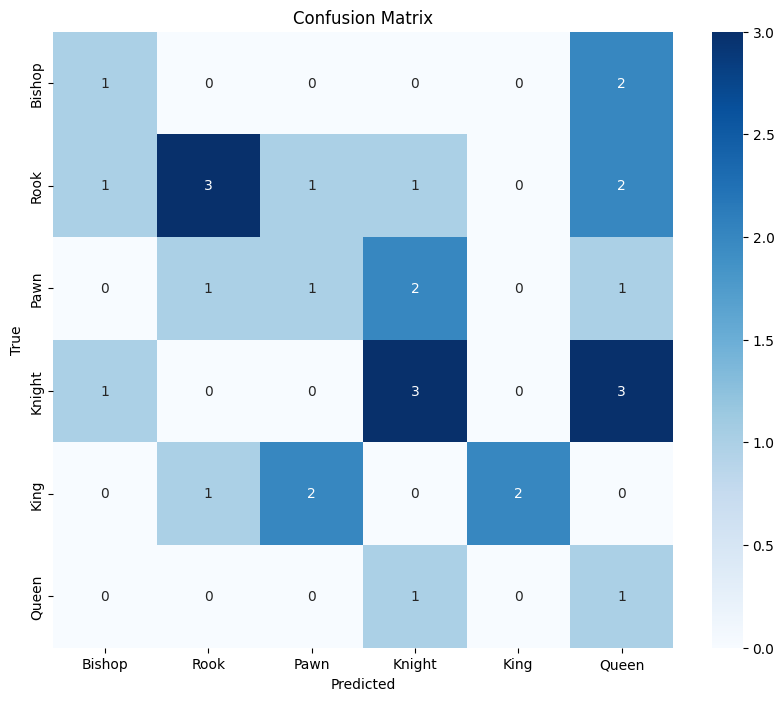

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_to_chess.values(), yticklabels=label_to_chess.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

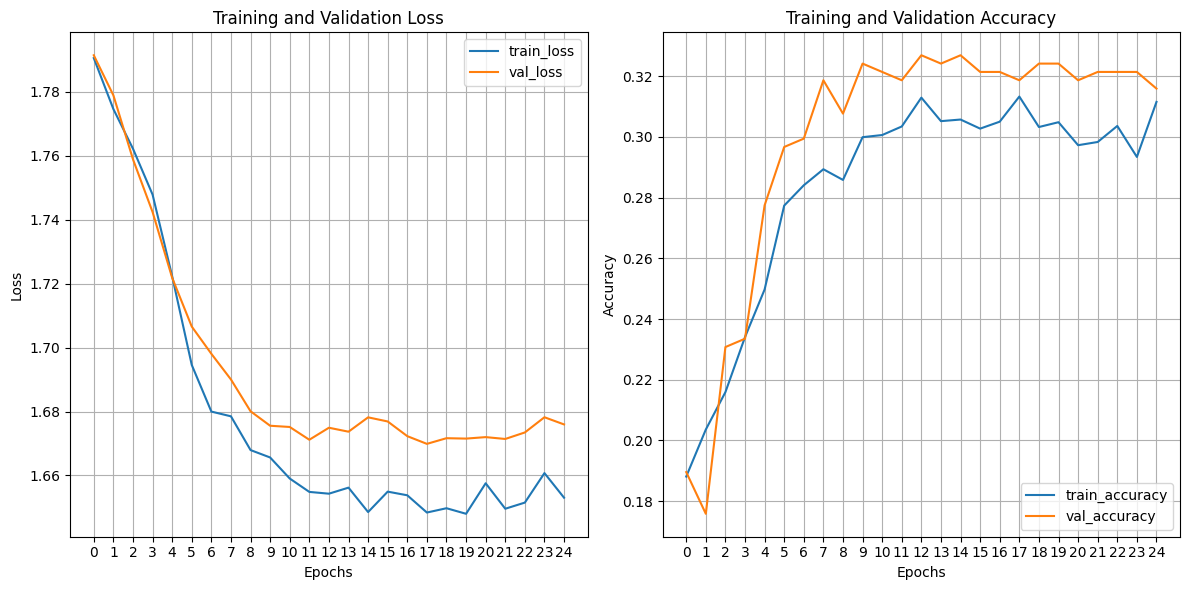

In [31]:
plot_training_metrics(epochs, train_losses, val_losses, train_accuracies, val_accuracies)

In [32]:
def plot_images(model, img_paths, t_imgs, labels = None):
    """
    Plots images along with their predicted and true labels.

    Args:
        model (nn.Module): The model to use for predictions.
        img_paths (list): A list of image file paths.
        t_imgs (torch.Tensor): A tensor containing the images.
        labels (torch.Tensor, optional): A tensor containing the true labels. Defaults to None.

    Returns:
        None

    This function visualizes the images along with their predicted and true labels.
    The best_idx0 and best_idx1 variables represent the top two predicted classes for each image,
    along with their corresponding probabilities. This helps in understanding the model's confidence
    in its predictions and seeing the second-best prediction.
    """
    _, axes = plt.subplots(
        math.ceil(len(img_paths) / 5),
        5,
        figsize=(15, 5 * math.ceil(len(img_paths) / 5)),
    )
    plt.tick_params(left=False, right=False, bottom=False)
    outputs = model(t_imgs.to(device))
    outputs = torch.softmax(outputs, dim=1)

    preds = outputs.argmax(1)
    best_indices = outputs.argsort(dim=1, descending=True)

    for i in range(len(preds)):
        img = Image.open(img_paths[i]).convert('RGB')
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].set_xticks([])
        axes[i // 5, i % 5].set_yticks([])

        best_idx0 = best_indices[i][0].item()
        best_idx1 = best_indices[i][1].item()
        title = ''
        if labels is not None:
            title += f'true: {label_to_chess[labels[i].item()]}\n'
        title += '-' * 20 + '\n'
        title += f'{label_to_chess[best_idx0]}: {outputs[i, best_idx0]:.3f}\n'
        title += f'{label_to_chess[best_idx1]}: {outputs[i, best_idx1]:.3f}\n'
        axes[i // 5, i % 5].set_title(title)

    plt.show()

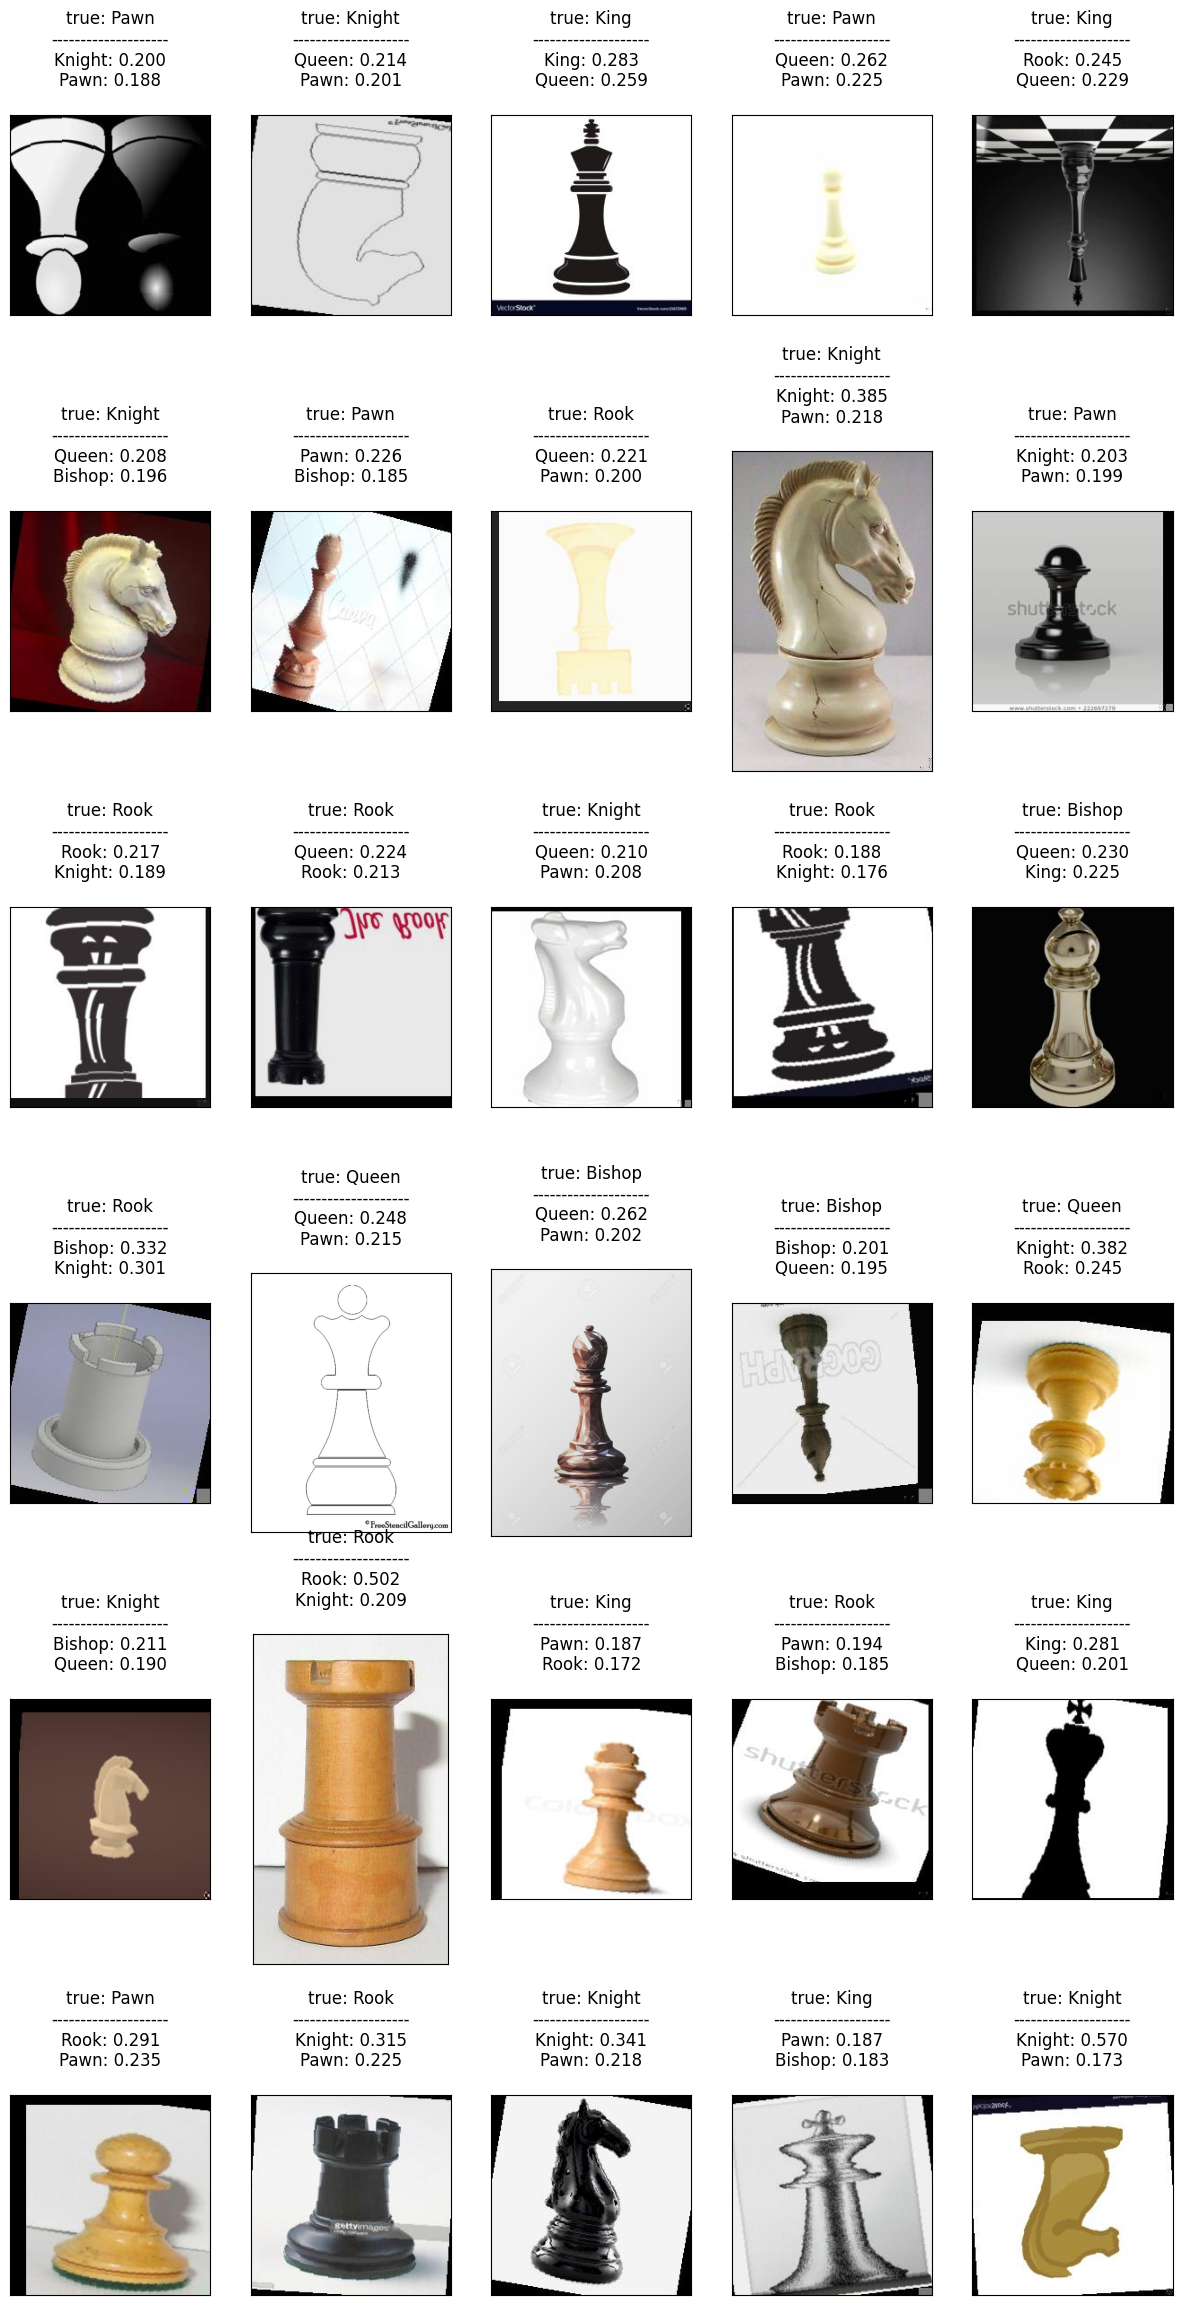

In [33]:
sample_data = Subset(test_dataset, range(30))
sample_loader = DataLoader(sample_data, batch_size=30)

with torch.no_grad():
    for img_paths, t_imgs, labels in test_loader:
        plot_images(base_model, img_paths, t_imgs, labels)

# Fine tuning PreTrained model - VGG16

In [ ]:
def setup_vgg16_for_finetuning(num_classes=12, lr_features=1e-4, lr_classifier_mid=5e-4, lr_classifier_final=1e-3):
    """
    Sets up a pre-trained VGG16 model for fine-tuning on a new classification task with 6 classes.

    Function Definition:
    The function `setup_vgg16_for_finetuning` sets up a pre-trained VGG16 model for fine-tuning on a new classification task.

    Arguments:
    - num_classes (int): The number of classes in the new classification task. Default is 6.
    - lr_features (float): Learning rate for the feature layers.
    - lr_classifier_mid (float): Learning rate for the middle classifier layers.
    - lr_classifier_final (float): Learning rate for the final classifier layer.

    Model Setup:
    - Loads a pre-trained VGG16 model.
    - Replaces the output layer to match the number of classes in the new task.
    - Sets the model to training mode.

    Parameter Selection:
    - Identifies and stores parameters to be updated based on specified layer names.
    - Sets `requires_grad` to `True` for parameters to be updated and `False` for others.

    Optimizer Setup:
    - Defines an SGD optimizer with different learning rates for different layers.

    Return:
    - Returns the model and the optimizer.
    """
    # Load pre-trained VGG16 model
    use_pretrained = models.VGG16_Weights.IMAGENET1K_V1
    net = models.vgg16(weights=use_pretrained)

    # Replace the output layer for the new number of classes
    net.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

    # Set the model to training mode
    net.train()

    # Lists to store parameters to be updated
    params_to_update_1 = []
    params_to_update_2 = []
    params_to_update_3 = []

    # Layer names to be updated
    update_param_names_1 = ["features"]
    update_param_names_2 = ["classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
    update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

    # Identify and store parameters to be updated
    for name, param in net.named_parameters():
        if any(layer in name for layer in update_param_names_1):
            param.requires_grad = True
            params_to_update_1.append(param)
            print("params_to_update_1:", name)
        elif name in update_param_names_2:
            param.requires_grad = True
            params_to_update_2.append(param)
            print("params_to_update_2:", name)
        elif name in update_param_names_3:
            param.requires_grad = True
            params_to_update_3.append(param)
            print("params_to_update_3:", name)
        else:
            param.requires_grad = False
            print("no learning:", name)

    print("-----------")
    print(params_to_update_1)

    # Define the optimizer with different learning rates for different layers
    optimizer = optim.SGD([
        {'params': params_to_update_1, 'lr': lr_features},
        {'params': params_to_update_2, 'lr': lr_classifier_mid},
        {'params': params_to_update_3, 'lr': lr_classifier_final}
    ], momentum=0.9)

    return net, optimizer

In [ ]:
model, optimizer = setup_vgg16_for_finetuning(num_classes=num_labels)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.9MB/s]


params_to_update_1: features.0.weight
params_to_update_1: features.0.bias
params_to_update_1: features.2.weight
params_to_update_1: features.2.bias
params_to_update_1: features.5.weight
params_to_update_1: features.5.bias
params_to_update_1: features.7.weight
params_to_update_1: features.7.bias
params_to_update_1: features.10.weight
params_to_update_1: features.10.bias
params_to_update_1: features.12.weight
params_to_update_1: features.12.bias
params_to_update_1: features.14.weight
params_to_update_1: features.14.bias
params_to_update_1: features.17.weight
params_to_update_1: features.17.bias
params_to_update_1: features.19.weight
params_to_update_1: features.19.bias
params_to_update_1: features.21.weight
params_to_update_1: features.21.bias
params_to_update_1: features.24.weight
params_to_update_1: features.24.bias
params_to_update_1: features.26.weight
params_to_update_1: features.26.bias
params_to_update_1: features.28.weight
params_to_update_1: features.28.bias
params_to_update_2: 

In [ ]:
epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader, device, scheduler=scheduler, is_pretrain=True)
    val_loss, val_accuracy = evaluate(model, criterion, val_loader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'epoch={epoch + 1}, train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, train_accuracy={train_accuracy:.3f}, val_accuracy={val_accuracy:.3f}')

Evaluating: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


epoch=1, train_loss=0.856, val_loss=0.569, train_accuracy=0.681, val_accuracy=0.816


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


epoch=2, train_loss=0.569, val_loss=0.364, train_accuracy=0.789, val_accuracy=0.874


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


epoch=3, train_loss=0.394, val_loss=0.279, train_accuracy=0.856, val_accuracy=0.901


Evaluating: 100%|██████████| 6/6 [00:03<00:00,  2.00it/s]


epoch=4, train_loss=0.293, val_loss=0.195, train_accuracy=0.892, val_accuracy=0.940


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


epoch=5, train_loss=0.210, val_loss=0.150, train_accuracy=0.921, val_accuracy=0.948


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]


epoch=6, train_loss=0.159, val_loss=0.128, train_accuracy=0.945, val_accuracy=0.959


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


epoch=7, train_loss=0.123, val_loss=0.109, train_accuracy=0.956, val_accuracy=0.962


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


epoch=8, train_loss=0.091, val_loss=0.114, train_accuracy=0.970, val_accuracy=0.970


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


epoch=9, train_loss=0.080, val_loss=0.084, train_accuracy=0.971, val_accuracy=0.975


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


epoch=10, train_loss=0.062, val_loss=0.087, train_accuracy=0.980, val_accuracy=0.970


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


epoch=11, train_loss=0.050, val_loss=0.071, train_accuracy=0.984, val_accuracy=0.981


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


epoch=12, train_loss=0.039, val_loss=0.070, train_accuracy=0.988, val_accuracy=0.984


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


epoch=13, train_loss=0.038, val_loss=0.063, train_accuracy=0.988, val_accuracy=0.981


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


epoch=14, train_loss=0.025, val_loss=0.055, train_accuracy=0.994, val_accuracy=0.984


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


epoch=15, train_loss=0.022, val_loss=0.063, train_accuracy=0.994, val_accuracy=0.978


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


epoch=16, train_loss=0.021, val_loss=0.053, train_accuracy=0.994, val_accuracy=0.986


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


epoch=17, train_loss=0.016, val_loss=0.057, train_accuracy=0.996, val_accuracy=0.986


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


epoch=18, train_loss=0.015, val_loss=0.064, train_accuracy=0.996, val_accuracy=0.986


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


epoch=19, train_loss=0.015, val_loss=0.060, train_accuracy=0.995, val_accuracy=0.984


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

epoch=20, train_loss=0.012, val_loss=0.056, train_accuracy=0.997, val_accuracy=0.986


In [ ]:
train_recall, train_precision, train_f1, train_misclassified, _ = calculate_metrics(model, train_loader, device)
val_recall, val_precision, val_f1, val_misclassified, _ = calculate_metrics(model, val_loader, device)
recall, precision, f1, misclassified_percentage, cm = calculate_metrics(model, test_loader, device)

print(f'Train Recall: {train_recall:.3f}%')
print(f'Train Precision: {train_precision:.3f}%')
print(f'Train F1 Score: {train_f1:.3f}')
print(f'Train Misclassified Classes: {train_misclassified:.3f}%\n')

print(f'Validation Recall: {val_recall:.3f}%')
print(f'Validation Precision: {val_precision:.3f}%')
print(f'Validation F1 Score: {val_f1:.3f}%')
print(f'Validation Misclassified Classes: {val_misclassified:.3f}%')

print(f"Recall: {recall:.3f}%")
print(f"Precision: {precision:.3f}%")
print(f"F1 Score: {f1:.3f}%")
print(f"Misclassified %: {misclassified_percentage:.3f}%")

Calculating Metrics: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]

Train Recall: 100.000%
Train Precision: 100.000%
Train F1 Score: 100.000
Train Misclassified Classes: 0.000%

Validation Recall: 98.626%
Validation Precision: 98.632%
Validation F1 Score: 98.624%
Validation Misclassified Classes: 1.374%
Recall: 96.667%
Precision: 97.222%
F1 Score: 96.633%
Misclassified %: 3.333%


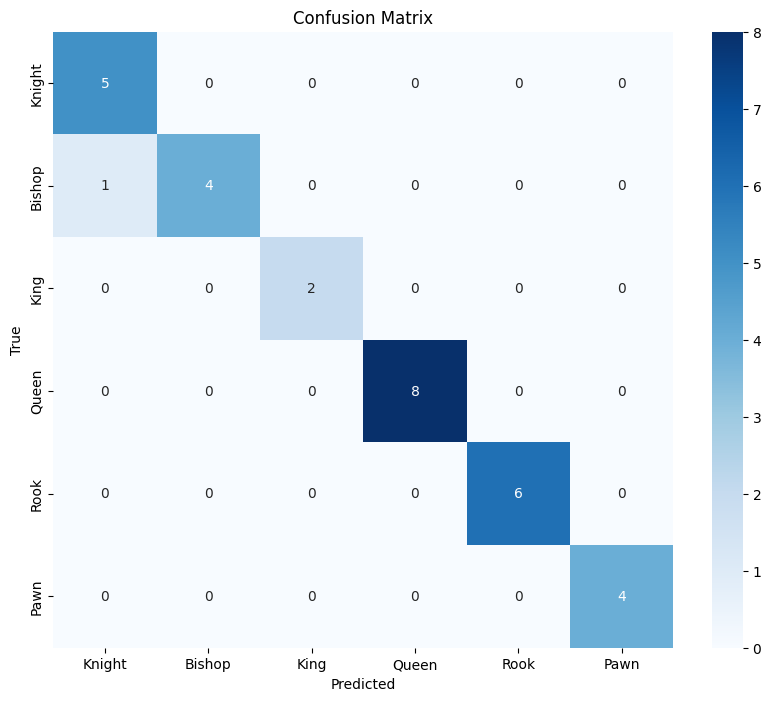

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_to_chess.values(), yticklabels=label_to_chess.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

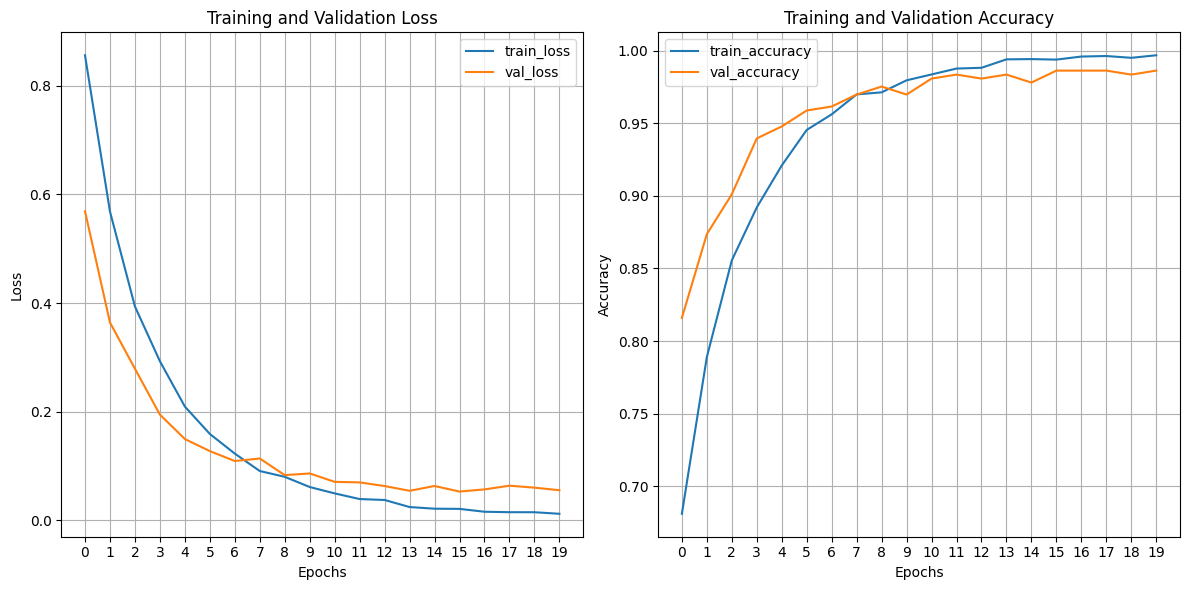

In [ ]:
plot_training_metrics(epochs, train_losses, val_losses, train_accuracies, val_accuracies)

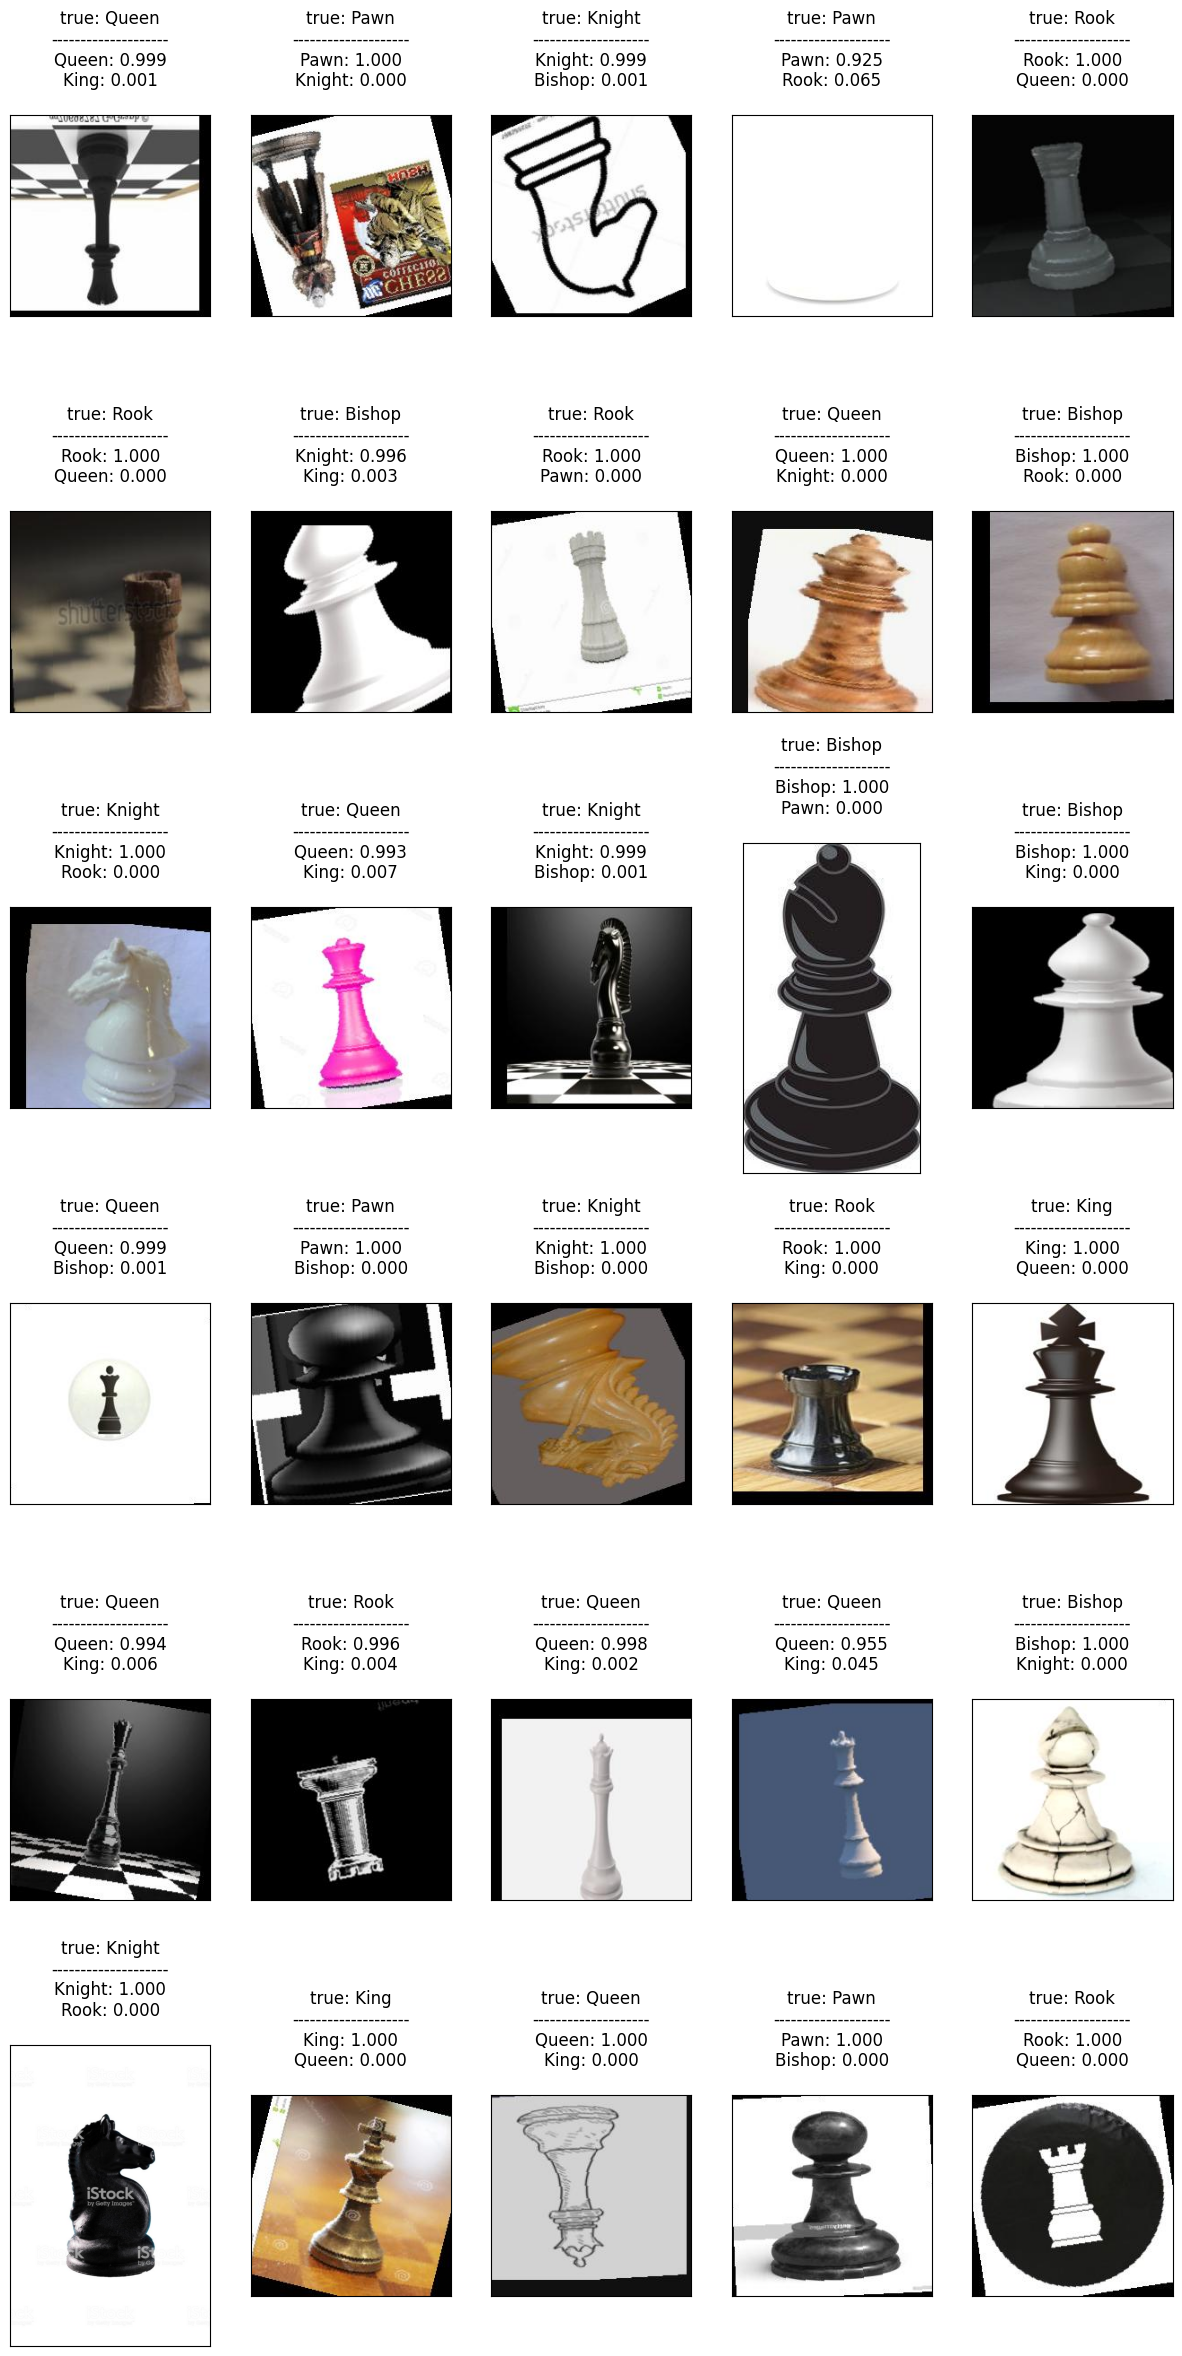

In [ ]:
with torch.no_grad():
    for img_paths, t_imgs, labels in test_loader:
        plot_images(model, img_paths, t_imgs, labels)

# Store the Models

In [35]:
model_path = os.path.join(BASEPATH, "stored_model")
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [ ]:
base_model

ChessClassifier(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=6, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.3, in

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
torch.save(base_model.state_dict(), os.path.join(model_path, "modelV1.bin"))

In [ ]:
torch.save(model.state_dict(), os.path.join(model_path, "vgg16_modelV1.bin"))

In [ ]:
folder_path = '/content/stored_model/vgg16_modelV1.bin'
zip_file_path = '/content/vgg16.zip'


with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zip_ref:
    for foldername, subfolders, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            zip_ref.write(file_path, os.path.relpath(file_path, folder_path))

print(f"Folder zipped to {zip_file_path}")

Folder zipped to /content/trained_models.zip


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from pathlib import Path
import time
from models import ChessClassifier
import torchvision.models as models

print(torch.backends.mps.is_available())
BASEPATH = Path("__file__").parent.resolve()

device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(device)

class ChessCategorizer(nn.Module):
    """
    A class to categorize chess pieces using a pre-trained VGG16 model and a custom chess classifier model.

    Args:
        model_path (str): Path to the directory containing the model files.
        label_to_chess (dict): A dictionary mapping class labels to chess piece names.
        threshold (float): The threshold for classification probability. Default is 0.3.
    """

    def __init__(
            self,
            model_path: str,
            label_to_chess: dict,
            device: str = 'cpu',
            base_model = "modelV1.bin",
            model = "vgg16_modelV1.bin",
            threshold: float = 0.3
            ):
        super(ChessCategorizer, self).__init__()

        self.in_features = 4096
        self.device = device
        self.num_labels = len(label_to_chess)
        self.base_model = base_model
        self.model = model
        class_labels = self._load()
        self.label_to_chess = label_to_chess
        self.threshold = threshold
        print("Loaded dictionary:", class_labels)
        print("Using", self.device)

        # Load VGG16 model
        self.net = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.net.classifier[6] = nn.Linear(in_features=self.in_features, out_features=self.num_labels)
        self.net.eval()
        self.net.load_state_dict(torch.load(f"{model_path}/{model}", map_location=torch.device(device=self.device)))
        time.sleep(0.05)  # Release memory before loading the next model

        # Load chessClassifier model
        self.model = ChessClassifier()
        self.model.load_state_dict(torch.load(f"{model_path}/{base_model}", map_location=torch.device(device=self.device)))
        self.model.eval()

    def _load(self, file_name='class_labels.json'):
        with open(str(BASEPATH / file_name), 'r') as json_file:
            return json.load(json_file)

    def predict(self, model, input_tensor):
        """
        Predict the class of the input tensor using the given model.

        Args:
            model (nn.Module): The model to use for prediction.
            input_tensor (torch.Tensor): The input tensor to classify.

        Returns:
            tuple: A tuple containing the predicted class, probability, and label.
        """
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)

        outputs = torch.softmax(output, dim=1)
        preds = torch.argmax(outputs).item()
        probs = outputs[0, preds]
        label = self.label_to_chess[preds]

        return preds, probs, label

    def classify(self, input_pil_image):
        """
        Classify the chess piece in the input PIL image.

        Args:
            input_pil_image (PIL.Image): The input image to classify.

        Returns:
            tuple: A tuple containing the predictions from both models.
        """
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        input_tensor = preprocess(input_pil_image).unsqueeze(0)

        # Get predictions from both models
        output_net = self.predict(self.net, input_tensor)
        output_model = self.predict(self.model, input_tensor)

        print(output_net, output_model)

        return output_net, output_model

In [ ]:
input_pil_image = Image.open(input_image_path).convert('RGB')
# Classify the chess piece in the image
categorizer.classify_chess(input_pil_image)

In [ ]:
# model_path = str(BASEPATH / 'train')
# color_classifier = ColorClassifier(model_path=model_path)
# input_pil_image = Image.open(str(BASEPATH / 'roi_p_images' / 'roi_36_1.jpg')).convert('RGB')
# print(type(input_pil_image))
# prediction = color_classifier.classify_color(input_pil_image)
# if prediction != "unknown":
#     print("Color:", prediction[2])
#     print("Predicted class:", prediction[0])
#     print("Probability:", prediction[1])
# else:
#     print(prediction)
#     print("Probabilities from both models do not exceed the threshold.")